In [1]:
!pip install git+https://github.com/NSCC-COGS/Aestheta.git --quiet
!pip install fiona --quiet
!pip install rasterio --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 225kB 18.0MB/s 
     |████████████████████████████████| 15.3MB 294kB/s 
     |████████████████████████████████| 19.1MB 1.2MB/s 


In [2]:
!wget -O benthic_ground_truth.zip https://nscc-my.sharepoint.com/:u:/g/personal/w0001006_campus_nscc_ca/EaYM7nvthFFPm7MXx357X4UBm-xe1uGJVOOg-WpXbPeWGQ?download=1 --quiet --show-progress
!wget -O PQ_Lidar_DEMo13.tif https://nscc-my.sharepoint.com/:i:/g/personal/w0001006_campus_nscc_ca/ETLMGXbg1GpKph8-J0TNs60B-wdefo7rmRwp6FNMdkVOUw?download=1 --quiet --show-progress
!wget -O PQ_RCD_50cm_Cubic.tif https://nscc-my.sharepoint.com/:i:/g/personal/w0001006_campus_nscc_ca/EeGmrgtNc9ZErvlXcVXfNaABsgdvFf7XTX-RprngA9KaCA?download=1 --quiet --show-progress

benthic_ground_trut 100%[===================>]   4.79K  --.-KB/s    in 0s      
PQ_Lidar_DEMo13.tif 100%[===================>] 375.34M   100MB/s    in 3.8s    
PQ_RCD_50cm_Cubic.t 100%[===================>]   1.73G   105MB/s    in 17s     


In [3]:
!unzip benthic_ground_truth.zip

Archive:  benthic_ground_truth.zip
 extracting: benthic_ground_truth.cpg  
  inflating: benthic_ground_truth.dbf  
  inflating: benthic_ground_truth.prj  
  inflating: benthic_ground_truth.sbn  
  inflating: benthic_ground_truth.sbx  
  inflating: benthic_ground_truth.shp  
  inflating: benthic_ground_truth.shx  


In [4]:
from aestheta import core
import fiona, rasterio
import rasterio.features
from matplotlib import pyplot as plt

In [5]:
vector_file = r'benthic_ground_truth.shp'
ortho_file = r'PQ_RCD_50cm_Cubic.tif'
dem_file = r'PQ_Lidar_DEMo13.tif'

In [46]:
shapefile = fiona.open(vector_file)
print(shapefile.bounds)
print(shapefile.meta)
a = shapefile[0]["geometry"]
a['coordinates'] = shapefile.bounds
print(a)
shapes = [feature["geometry"] for feature in shapefile]
print(shapes)

(591310.2537867589, 5051605.3409948815, 594720.8720664426, 5055134.216354804)
{'driver': 'ESRI Shapefile', 'schema': {'properties': OrderedDict([('Id', 'int:6'), ('Cover_type', 'str:25')]), 'geometry': 'Polygon'}, 'crs': {'init': 'epsg:26920'}, 'crs_wkt': 'PROJCS["NAD83 / UTM zone 20N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-63],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26920"]]'}
{'type': 'Polygon', 'coordinates': (591310.2537867589, 5051605.3409948815, 594720.8720664426, 5055134.216354804)}
[{'type': '

In [110]:
def bounds_to_poly(bounds):
  l,t,r,b = bounds
  poly = [(l,t),
          (r,t),
          (r,b),
          (l,b),
          (l,t)]
  return poly


In [109]:
bounds_to_polygon(shapefile.bounds)

591310.2537867589
5051605.3409948815
594720.8720664426
5055134.216354804


In [113]:
def clip_raster(raster_file, vector_file, raster_out, masked = False):
  # https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html
  import fiona
  import rasterio
  import rasterio.mask

  with fiona.open(vector_file, "r") as shapefile:
    if masked: # iterate over every poly to make clip geometry
      shapes = [feature["geometry"] for feature in shapefile]
      print(shapes)
    else: # just clip by the whole bounds
      shapes = shapefile[0]["geometry"] #get a json template from the first poly
      print(shapefile.bounds)
      poly_bounds = bounds_to_poly(shapefile.bounds)
      shapes['coordinates'] = [poly_bounds] # replace coords with bounds
      shapes = [shapes]
      print(shapes)
  
  # return
  # input('yeah?')
  with rasterio.open(raster_file) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

  with rasterio.open(raster_out, "w", **out_meta) as dest:
      dest.write(out_image)

In [115]:
ortho_clip_file = ortho_file.replace('.tif', '_clipped.tif')
clip_raster(ortho_file, vector_file, ortho_clip_file, masked=False)
# clip_raster(ortho_file, vector_file, ortho_clip_file, masked=True)

(591310.2537867589, 5051605.3409948815, 594720.8720664426, 5055134.216354804)
[{'type': 'Polygon', 'coordinates': [[(591310.2537867589, 5051605.3409948815), (594720.8720664426, 5051605.3409948815), (594720.8720664426, 5055134.216354804), (591310.2537867589, 5055134.216354804), (591310.2537867589, 5051605.3409948815)]]}]


In [116]:
def snap_raster(raster_file, snap_raster_file, raster_out):
  #https://stackoverflow.com/questions/59102791/how-to-find-corresponding-pixels-between-two-geospatial-raster-data-with-differe

  from rasterio.warp import calculate_default_transform, reproject, Resampling

  raz = rasterio.open(raster_file)
  snp = rasterio.open(snap_raster_file)


  kwargs = raz.meta.copy()
  kwargs.update({
      'crs': snp.crs,
      'transform': snp.transform,
      'width': snp.width,
      'height': snp.height
  })

  with rasterio.open(raster_out, 'w', **kwargs) as dst:
      reproject(
          source=rasterio.band(raz, 1),
          destination=rasterio.band(dst, 1),
          src_transform=raz.transform,
          src_crs=raz.crs,
          dst_transform=snp.transform,
          dst_crs=snp.crs,
          resampling=Resampling.nearest)

In [117]:
dem_clip_file = dem_file.replace('.tif', '_clipped.tif')
snap_raster(dem_file, ortho_clip_file, dem_clip_file)

38.60896


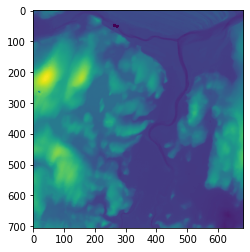

In [118]:
import imageio
dem = imageio.imread(dem_clip_file)
print(dem.max())
plt.imshow(dem[::10,::10], vmin=-10)
plt.show()

255


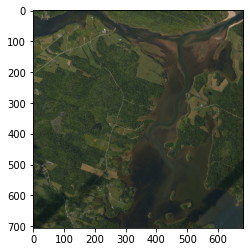

In [119]:
ortho = imageio.imread(ortho_clip_file)
print(ortho.max())
plt.imshow(ortho[::10,::10,0:3])
plt.show()

In [120]:
image1 = ortho[::10,::10,0]
image2 = dem[::10,::10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in multiply
  """Entry point for launching an IPython kernel.


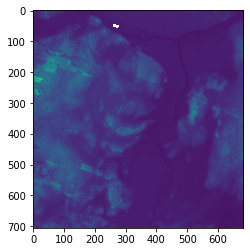

In [121]:
plt.imshow(image1 * image2)

In [122]:
image1 = ortho[::10,::10,0]
image2 = dem[::10,::10]

In [124]:
def add_features_from_vec(raster_file , vector_file):
  src = rasterio.open(raster_file)

  shapefile = fiona.open(vector_file)
  geom = [shapes['geometry'] for shapes in shapefile]
  # attrib = [shapes['properties'] for shapes in shapefile]

  image = rasterio.features.rasterize(geom, out_shape=src.shape, transform=src.transform)
  return image

In [125]:
image = add_features_from_vec(ortho_file,vector_file)

In [126]:
def add_features_from_vec_col(raster_file , vector_file,col):
# https://gis.stackexchange.com/questions/297920/rasterizing-by-attribute-in-rasterio

  src = rasterio.open(raster_file)
  shapefile = fiona.open(vector_file)
  geom = [[shapes['geometry'],shapes['properties'][col]] for shapes in shapefile]

  varray = rasterio.features.rasterize(geom,
                    out_shape=src.shape, 
                    transform=src.transform,
                    fill=-1,
                    default_value=1,
                    all_touched=True)
  return varray

In [128]:
image_col = add_features_from_vec_col(ortho_clip_file,vector_file, col = 'Id')

In [129]:
import numpy as np
print(np.unique(image_col))

[-1  1  2  3  4  5  6  7]


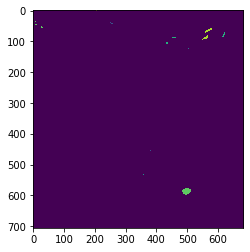

In [130]:
plt.imshow(image_col[::10,::10], interpolation='nearest')

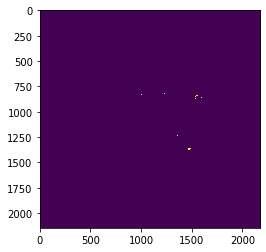

In [131]:
plt.imshow(image[::10,::10], interpolation='nearest')

In [133]:
mask = image_col>-1
X = ortho[mask]
y = image_col[mask]

In [208]:
print(X)

[[ 0  0  0  0]
 [ 0  0  0  0]
 [53 60 61 80]
 ...
 [62 64 47 48]
 [ 0  0  0  0]
 [ 0  0  0  0]]


In [209]:
print(y)

[7 7 7 ... 1 1 1]


In [134]:
from sklearn.ensemble import GradientBoostingClassifier

classModel = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=1,
        random_state=0,
        verbose=1
    ).fit(X, y)

      Iter       Train Loss   Remaining Time 
         1      109953.9522           47.28s
         2       94942.1334           44.99s
         3       83467.0865           43.95s
         4       74257.9170           42.85s
         5       66727.0002           42.38s
         6       60464.9579           41.84s
         7       55121.7758           41.27s
         8       50600.4914           40.88s
         9       46713.1244           40.31s
        10       43168.3982           39.82s
        20       23195.9872           34.82s
        30       15781.9432           30.33s
        40       12105.9781           25.92s
        50       10225.5888           21.54s
        60        8597.9137           17.19s
        70        7538.3793           12.87s
        80        6748.3215            8.57s
        90        6101.1002            4.28s
       100        5621.1532            0.00s


In [193]:
example_model, example_classes = core.loadModel()
print(example_classes)

['simpleClassifier_20210302180953_64_HelloEarth100.aist', 'simpleClassifier_20210317122725_64_HelloEarth100.aist', 'simpleClassifier_20210317123255_64_HelloEarth100.aist', 'simpleClassifier_20210228223109_32_HelloEarth100.aist', 'simpleClassifier_20210228221023_32_HelloEarth.aist', 'simpleClassifier_20210317122843_64_HelloEarth100.aist', 'simpleClassifier_20210317122912_64_HelloEarth100.aist']
getting most recent model
20210302180953
20210317122725
20210317123255
20210228223109
20210228221023
20210317122843
20210317122912
/usr/local/lib/python3.7/dist-packages/aestheta/Models/simpleClassifier_20210317123255_64_HelloEarth100.aist


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


[[133  95 129 255]
 [135 117 160 255]
 [136 138 189 255]
 [136 149 204 255]
 [137 159 219 255]
 [138 170 234 255]
 [138 180 248 255]
 [141 188 228 255]
 [143 160 127 255]
 [144 184 248 255]
 [146 201 192 255]
 [148 188 234 255]
 [148 210 165 255]
 [150 187 247 255]
 [153 191 227 255]
 [153 199 215 255]
 [157 214 172 255]
 [162 194 246 255]
 [168 201 204 255]
 [168 218 181 255]
 [172 212 214 255]
 [173 220 186 255]
 [174 201 245 255]
 [178 207 189 255]
 [178 222 190 255]
 [187 226 198 255]
 [196 228 206 255]
 [198 215 242 255]
 [206 178 181 255]
 [208 210 213 255]
 [209 221 240 255]
 [210 230 218 255]
 [211 228 202 255]
 [214 216 219 255]
 [221 223 226 255]
 [221 228 239 255]
 [225 232 210 255]
 [232 234 237 255]
 [238 240 238 255]
 [241 233 215 255]
 [243 243 243 255]
 [245 240 228 255]
 [255 255 255 255]]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [210]:
#lets make our classes fit our classify image tool
classes = np.arange(y.max()+1, dtype=float)
print(classes)
print('-------------')
classes  = np.repeat(classes[:, np.newaxis], 3, axis=1)
classes -= classes.min()
classes /= classes.max()
classes *= 255
print(classes)
print('-------------')
alpha  = (np.ones((classes.shape[0],1))*255)
print(alpha)
print('-------------')
classes = np.hstack((classes,alpha)).astype(int)
print(classes)

[0. 1. 2. 3. 4. 5. 6. 7.]
-------------
[[  0.           0.           0.        ]
 [ 36.42857143  36.42857143  36.42857143]
 [ 72.85714286  72.85714286  72.85714286]
 [109.28571429 109.28571429 109.28571429]
 [145.71428571 145.71428571 145.71428571]
 [182.14285714 182.14285714 182.14285714]
 [218.57142857 218.57142857 218.57142857]
 [255.         255.         255.        ]]
-------------
[[255.]
 [255.]
 [255.]
 [255.]
 [255.]
 [255.]
 [255.]
 [255.]]
-------------
[[  0   0   0 255]
 [ 36  36  36 255]
 [ 72  72  72 255]
 [109 109 109 255]
 [145 145 145 255]
 [182 182 182 255]
 [218 218 218 255]
 [255 255 255 255]]


In [211]:
ortho_class = core.classifyImage(ortho[::10,::10],classModel,classes)

applying classification...


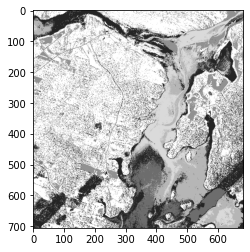

In [212]:
plt.imshow(ortho_class)

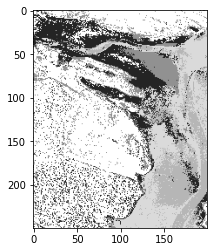

In [213]:
plt.imshow(ortho_class[50:300,300:500])

In [ ]:
#copy something into 4 channels 

import numpy as np
imageRGBA = np.repeat(image[:, :, np.newaxis], 3, axis=2)

plt.imshow(imageRGBA[::10,::10], interpolation='nearest')

In [ ]:
model,classes = core.simpleClassifier(ortho[::10,::10,0:3],imageRGBA[::10,::10])

In [123]:
#leftovers
def reproject(imageFile):
    '''this is a boilerplate example of how image reporjection can be done using rasterio'''
    import numpy as np
    import rasterio
    from rasterio.warp import calculate_default_transform, reproject, Resampling

    # dst_crs = 'EPSG:4326'
    dst_crs = 'EPSG:3857' # web mercator 

    with rasterio.open(imageFile) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open('testLandsat.tif', 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
